In [2]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, decimate
from ahrs.filters import EKF
from ahrs.common.orientation import q2euler
import os
import glob
from io import StringIO

In [42]:
def load_txt(file):
    """
    Loads either a .txt or .csv data file into a pandas DataFrame.
    Automatically detects file type, separator, and encoding.
    Cleans up column names for safe downstream processing.
    """
    if file.endswith(".csv"):
        # --- CSV case ---
        try:
            df = pd.read_csv(file, encoding="utf-8")
        except UnicodeDecodeError:
            # Handle Windows or European encodings (μ, °, etc.)
            df = pd.read_csv(file, encoding="latin1")
        except pd.errors.ParserError:
            df = pd.read_csv(file, sep=";", encoding="latin1")
    else:
        # --- TXT case ---
        with open(file, "r", encoding="utf-8", errors="replace") as f:
            lines = f.readlines()
        # Drop empty lines
        lines = [line for line in lines if line.strip()]
        header_line = lines[1].strip().split("\t")
        data_lines = lines[2:]
        df = pd.read_csv(StringIO("".join(data_lines)), sep="\t", names=header_line)

    # --- Clean up column names ---
    df.columns = (
        df.columns.str.replace("�", "u", regex=False)   # Replace invalid chars
                   .str.replace("µ", "u", regex=False)
                   .str.strip()
    )
    return df


# --- Folder containing your files ---
folder_path = "measurement/20_10"  # change as needed

# --- Find all .txt and .csv files ---
txt_files = glob.glob(os.path.join(folder_path, "*.txt")) + \
            glob.glob(os.path.join(folder_path, "*.csv"))

# --- Read all files into a dictionary ---
data = {}
for file in txt_files:
    df = load_txt(file)
    data[os.path.basename(file)] = df

# --- Quick check ---
print(f"✅ Loaded {len(data)} files:")
for name in data.keys():
    print(" •", name)
print("\nFirst file columns:")
print(list(data[list(data.keys())[0]].columns))

df = load_txt(txt_files[2])

✅ Loaded 3 files:
 • wavex_20251020_161647.csv
 • wavex_20251020_161939.csv
 • wavex_20251020_174747.csv

First file columns:
['Time(s)', 'Emg_5(uV)', 'Emg_6(uV)', 'Imu_5_ImuAcc:X(g)', 'Imu_6_ImuAcc:X(g)', 'Imu_5_ImuAcc:Y(g)', 'Imu_6_ImuAcc:Y(g)', 'Imu_5_ImuAcc:Z(g)', 'Imu_6_ImuAcc:Z(g)', 'Imu_5_ImuGyro:X(D/s)', 'Imu_6_ImuGyro:X(D/s)', 'Imu_5_ImuGyro:Y(D/s)', 'Imu_6_ImuGyro:Y(D/s)', 'Imu_5_ImuGyro:Z(D/s)', 'Imu_6_ImuGyro:Z(D/s)', 'Imu_5_ImuMag:X(uT)', 'Imu_6_ImuMag:X(uT)', 'Imu_5_ImuMag:Y(uT)', 'Imu_6_ImuMag:Y(uT)', 'Imu_5_ImuMag:Z(uT)', 'Imu_6_ImuMag:Z(uT)']


In [43]:
#Spaltennamen
sensor_id = 6

acc_cols = [f"Imu_{sensor_id}_ImuAcc:X(g)", f"Imu_{sensor_id}_ImuAcc:Y(g)", f"Imu_{sensor_id}_ImuAcc:Z(g)"]
gyr_cols = [f"Imu_{sensor_id}_ImuGyro:X(D/s)", f"Imu_{sensor_id}_ImuGyro:Y(D/s)", f"Imu_{sensor_id}_ImuGyro:Z(D/s)"]
mag_cols = [f"Imu_{sensor_id}_ImuMag:X(uT)", f"Imu_{sensor_id}_ImuMag:Y(uT)", f"Imu_{sensor_id}_ImuMag:Z(uT)"]

# identify sample rate
time = df["Time(s)"].to_numpy()
dt = np.diff(time)
fs = 1 / np.median(dt)  # Hz
print(fs)
print(df)

2000.0000000002203
       Time(s)  Emg_5(uV)  Emg_6(uV)  Imu_5_ImuAcc:X(g)  Imu_6_ImuAcc:X(g)  \
0       0.0000      -3300  -0.100708          -8.000244          -0.031495   
1       0.0005      -3300  -0.100708          -8.000244          -0.034388   
2       0.0010      -3300  -0.100708          -8.000244          -0.037281   
3       0.0015      -3300  -0.100708          -8.000244          -0.040175   
4       0.0020      -3300  -0.100708          -8.000244          -0.043068   
...        ...        ...        ...                ...                ...   
89295  44.4325      -3300  -3.121948          -8.000244           0.002503   
89296  44.4330      -3300   0.704956          -8.000244           0.002441   
89297  44.4335      -3300  -0.100708          -8.000244           0.002380   
89298  44.4340      -3300  -4.934692          -8.000244           0.002319   
89299  44.4345      -3300  -0.604248          -8.000244           0.002258   

       Imu_5_ImuAcc:Y(g)  Imu_6_ImuAcc:Y(g) 

In [45]:
# =====================================
# 2. Erste 0.1s entfernen
# =====================================
cut_samples = int(0.1 * fs)
df = df.iloc[cut_samples:].reset_index(drop=True)
df["Time(s)"] = df["Time(s)"] - df["Time(s)"].iloc[0]

# =====================================
# 3. Einheitenskalierung
# =====================================
g = 9.80665
df[acc_cols] *= g      # g → m/s²
df[gyr_cols] *= np.pi/180  # °/s → rad/s
df[mag_cols] *= 1e3        # µT → nT (oder einfach lassen, EKF kann beides, wichtig ist Normierung)

# =====================================
# 4. Downsampling auf 100 Hz (optional)
# =====================================
target_fs = 100
factor = int(fs / target_fs)

df = df.iloc[::factor, :].reset_index(drop=True)
fs = target_fs

# =====================================
# 5. Butterworth Tiefpassfilter (fc=15Hz)
# =====================================
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

fc = 15
df_filt = df.copy()
#filtering for acc and gyr
for col in acc_cols + gyr_cols:
    df_filt[col] = butter_lowpass_filter(df[col], fc, fs)

# Magnetometer NICHT tiefpassfiltern:
# - Magnetfelder ändern sich langsam
# - Filter könnte Nutzsignal verfälschen
# Optional: Normalisierung auf Einheitssphäre
mag = df[mag_cols].to_numpy()
mag /= np.linalg.norm(mag, axis=1)[:, None]
df_filt[mag_cols] = mag

# =====================================
# 6. Arrays für EKF
# =====================================
acc = df_filt[acc_cols].to_numpy()
gyr = df_filt[gyr_cols].to_numpy()
mag = df_filt[mag_cols].to_numpy()


X-Auslenkung: -23.76 mm bis 40.66 mm
Y-Auslenkung: -3.86 mm bis 30.31 mm


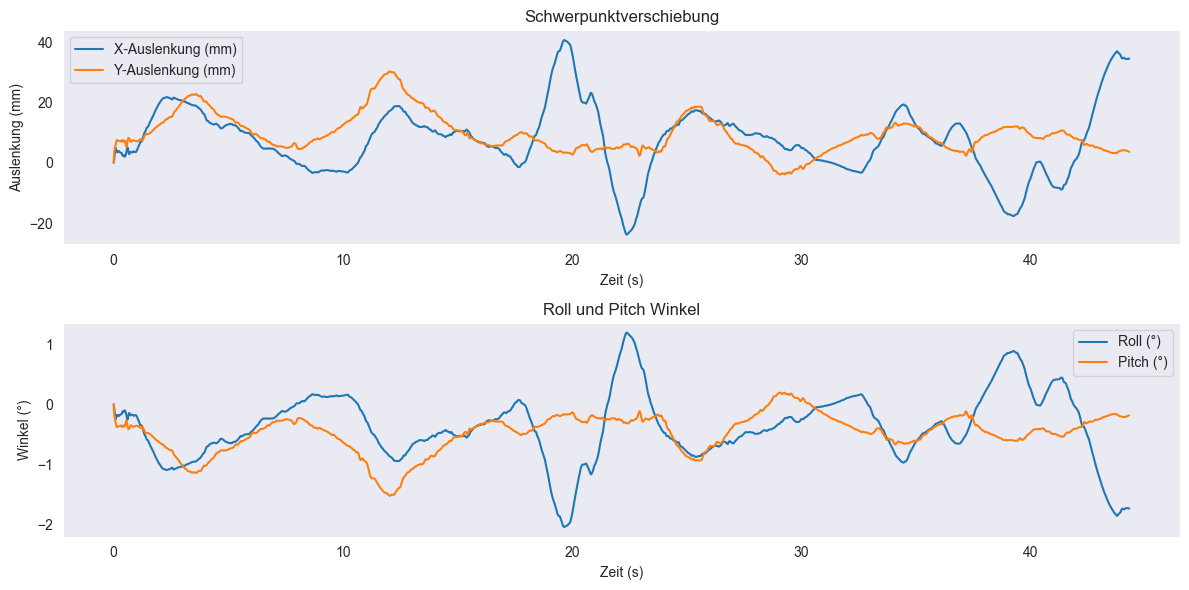

In [57]:
# =====================================
# 7. EKF Initialisierung
# =====================================
ekf = EKF(gyr=gyr, acc=acc, frequency=target_fs)

# Convert all quaternions to Euler angles (roll, pitch, yaw)
euler_angles = np.array([q2euler(q_) for q_ in ekf.Q])
euler_deg = np.degrees(euler_angles)
################################################################
# ekf = EKF(frequency=target_fs)
# N = len(df_filt)
# quaternions = np.zeros((N, 4))
# for t in range(1, N):
#     ekf.update(acc[t], gyr[t], mag[t])
#     quaternions[t] = ekf.q
#
# # =====================================
# # 8. Eulerwinkel (Roll, Pitch, Yaw)
# # =====================================
# euler = q2euler(quaternions)  # [roll, pitch, yaw] in rad
#################################################################

roll = euler_angles[:, 0]
pitch = euler_angles[:, 1]
yaw = euler_angles[:, 2]

# =====================================
# 9. Winkel unwrap + auf 0 normieren
# =====================================
roll = np.unwrap(roll)
pitch = np.unwrap(pitch)

# Da sich dein Sensor kaum bewegt: unwrap ist oft NICHT nötig.
# Aber bei langen Messungen ist es sicherer, es anzuwenden.
roll -= roll[0]
pitch -= pitch[0]

# =====================================
# 10. Schwerpunktverschiebung berechnen
# =====================================
# Annahme: Sensorhöhe (z in mm)
z = 1140  # mm, Beispielwert
x_disp = -z * np.sin(roll)
y_disp = -z * np.sin(pitch)



# =====================================
# 11. Max/min Auslenkung
# =====================================
x_max, x_min = np.max(x_disp), np.min(x_disp)
y_max, y_min = np.max(y_disp), np.min(y_disp)

print(f"X-Auslenkung: {x_min:.2f} mm bis {x_max:.2f} mm")
print(f"Y-Auslenkung: {y_min:.2f} mm bis {y_max:.2f} mm")

# =====================================
# 12. Plotten auf Ebene transversalebene
# =====================================


import matplotlib.pyplot as plt
time = df_filt["Time(s)"].to_numpy()

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, x_disp, label="X-Auslenkung (mm)")
plt.plot(time, y_disp, label="Y-Auslenkung (mm)")
plt.xlabel("Zeit (s)")
plt.ylabel("Auslenkung (mm)")
plt.title("Schwerpunktverschiebung")
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.plot(time, roll * (180/np.pi), label="Roll (°)")
plt.plot(time, pitch * (180/np.pi), label="Pitch (°)")
plt.xlabel("Zeit (s)")
plt.ylabel("Winkel (°)")
plt.title("Roll und Pitch Winkel")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


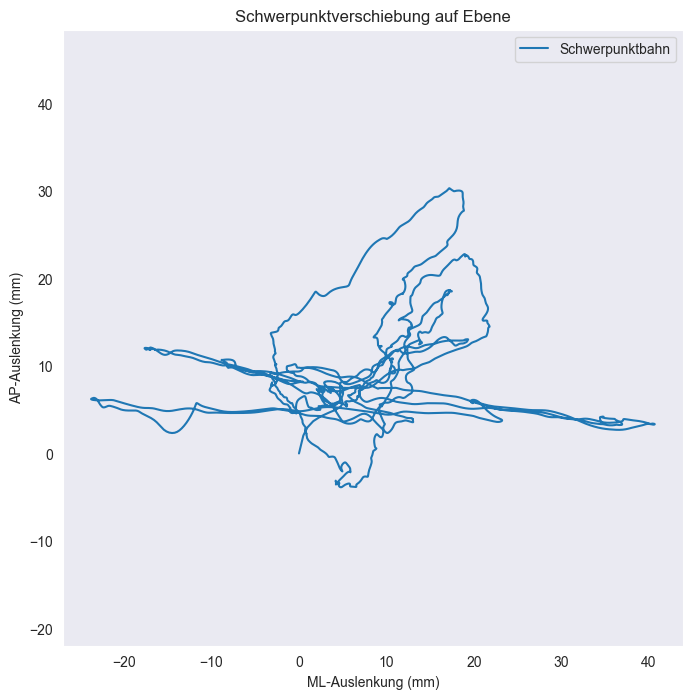

In [55]:
# plot x and y displacment on a 2D plane
plt.figure(figsize=(8, 8))
plt.plot(x_disp, y_disp, label="Schwerpunktbahn")
plt.xlabel("ML-Auslenkung (mm)")
plt.ylabel("AP-Auslenkung (mm)")
plt.title("Schwerpunktverschiebung auf Ebene")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()
